# Grokking Playground

## Imports

In [15]:
import contextlib
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn

from pathlib import Path
from torchvision import datasets, transforms
from tqdm.auto import tqdm

## Settings

In [61]:
seed = 64
run_name = "initial"
dtype = torch.float
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cache_dir = Path("../cache")

output_dir = cache_dir / "runs" / run_name

In [62]:
torch.set_default_dtype(dtype)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
random.seed(seed)
np.random.seed(seed)

In [63]:
cache_dir.mkdir(parents=True, exist_ok=True)
output_dir.mkdir(parents=True, exist_ok=True)

## Hyper-/Parameters

In [5]:
sample_size = 1000
batch_size = 200
optimization_steps = 1e5
log_freq = np.ceil(optimization_steps / 150)

In [6]:
initialization_scale = 8.0
learning_rate = 1e-3
weight_decay = 0.01

## Data

In [7]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)), # MNIST mean/std
])

In [8]:
train = datasets.MNIST(
    root=cache_dir,
    train=True, 
    transform=transform,
    download=True
)
test = datasets.MNIST(
    root=cache_dir,
    train=False, 
    transform=transform,
    download=True
)

train_subset, _ = torch.utils.data.random_split(train, [sample_size, len(train) - sample_size])

train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size, shuffle=True)

## Model

In [9]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 200),
    nn.ReLU(),
    nn.Linear(200, 200),
    nn.ReLU(),
    nn.Linear(200, 10)
).to(device)

In [10]:
with torch.no_grad():
    for p in model.parameters():
        p.data *= initialization_scale

In [11]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
loss_fn = nn.MSELoss()

## Training

In [ ]:
@contextlib.contextmanager
def eval_mode(model):
    model.eval()
    try:
        with torch.no_grad():
            yield
    finally:
        model.train()

In [13]:
eval_train_loader = torch.utils.data.DataLoader(train_subset, batch_size=batch_size)
eval_test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size)

def eval(storage, mode):
    loader = eval_train_loader if mode == "train" else eval_test_loader
    one_hots = torch.eye(10, 10).to(device)

    loss = 0
    correct = 0
    number = 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss += loss_fn(logits, one_hots[y]).item()
        labels = torch.argmax(logits, dim=1)
        correct += torch.sum(labels == y.to(device)).item()
        number += x.size(0)

    storage[mode]["loss"].append(loss/number)
    storage[mode]["accuracy"].append(correct/number)

In [14]:
data_collection = {
    "train": {
        "loss": [],
        "accuracy": [],
    },
    "test": {
        "loss": [],
        "accuracy": [],
    },
    "norms": [],
    "last_layer_norms": [],
    "steps": [],
}
one_hots = torch.eye(10, 10).to(device)
step = 0

with tqdm(total=optimization_steps) as pbar:
    while step < optimization_steps:
        for x, y in train_loader:
            if step >= optimization_steps:
                break

            if (step < 30) or (step < 150 and step % 10 == 0) or step % log_freq == 0:
                data_collection["steps"].append(step)
                with eval_mode(model):
                    eval(data_collection, "train")
                    eval(data_collection, "test")
                    all_layer = sum(torch.pow(p, 2).sum().item() for p in model.parameters())
                    data_collection["norms"].append(float(np.sqrt(all_layer)))
                    last_layer = sum(torch.pow(p, 2).sum().item() for p in model[-1].parameters())
                    data_collection["last_layer_norms"].append(float(np.sqrt(last_layer)))
                pbar.set_description("L: {0:1.1e}|{1:1.1e}. A: {2:2.1f}%|{3:2.1f}%".format(
                    data_collection["train"]["loss"][-1],
                    data_collection["test"]["loss"][-1],
                    data_collection["train"]["accuracy"][-1] * 100,
                    data_collection["test"]["accuracy"][-1] * 100,
                ))

            optimizer.zero_grad()
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fn(logits, one_hots[y])
            loss.backward()
            optimizer.step()

            step += 1
            pbar.update(1)

L: 2.8e-09|9.9e-05. A: 100.0%|89.7%: 100%|██████████| 100000/100000.0 [14:22<00:00, 115.88it/s]


## Evaluation

Text(0.5, 1.0, 'Run')

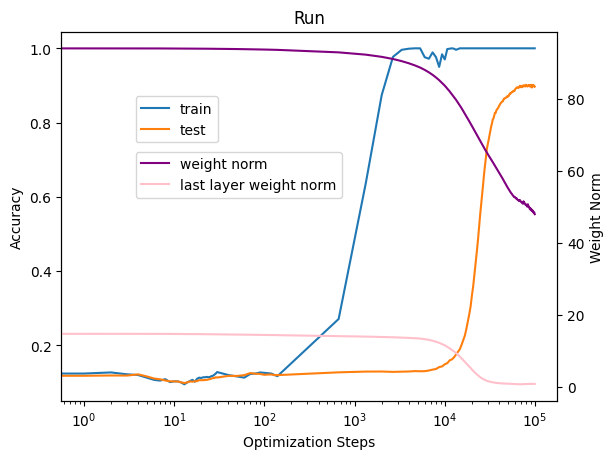

In [52]:
ax = plt.subplot(1, 1, 1)
plt.xlabel("Optimization Steps")
plt.xscale('log')

plt.ylabel("Accuracy")
plt.plot(data_collection["steps"], data_collection["train"]["accuracy"], label="train")
plt.plot(data_collection["steps"], data_collection["test"]["accuracy"], label="test")
plt.legend(loc=(0.15, 0.7))

ax2 = ax.twinx()
ax2.set_ylabel("Weight Norm")
ax2.plot(data_collection["steps"], data_collection["norms"], color="purple", label="weight norm")
ax2.plot(data_collection["steps"], data_collection["last_layer_norms"], color="pink", label="last layer weight norm")
plt.legend(loc=(0.15, 0.55))

plt.title("Run")

Text(0.5, 1.0, 'Run')

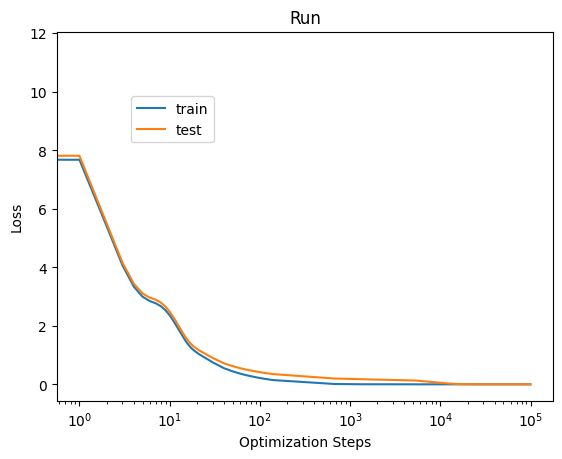

In [56]:
ax = plt.subplot(1, 1, 1)
plt.xlabel("Optimization Steps")
plt.xscale('log')

plt.ylabel("Loss")
plt.plot(data_collection["steps"], data_collection["train"]["loss"], label="train")
plt.plot(data_collection["steps"], data_collection["test"]["loss"], label="test")
plt.legend(loc=(0.15, 0.7))

plt.title("Run")

## Save

In [64]:
torch.save(model.state_dict(), output_dir / "model.pth")

In [65]:
onnx_program = torch.onnx.export(model, x, dynamo=True)
if onnx_program:
    onnx_program.save(output_dir / "model.onnx")

[torch.onnx] Obtain model graph for `Sequential([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `Sequential([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
